In [ ]:
# Colab cell
# Only run once at top of notebook
!pip install -q torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu118
!pip install -q transformers datasets diffusers accelerate safetensors ftfy sentence-transformers
!pip install -q einops wandb pillow matplotlib


In [ ]:
# Python cell
import os, random, math, time
from pathlib import Path
from pprint import pprint
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageDraw

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, utils
from torchvision.utils import make_grid, save_image

from datasets import load_dataset
from transformers import CLIPTokenizer, CLIPTextModel
from sentence_transformers import SentenceTransformer

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

# small helper
def show_images_grid(imgs, titles=None, nrow=4, figsize=(12,8)):
    if isinstance(imgs, torch.Tensor):
        imgs = imgs.detach().cpu()
        imgs = (imgs + 1)/2  # convert to [0,1]
        grid = make_grid(imgs, nrow=nrow, padding=2)
        plt.figure(figsize=figsize)
        plt.imshow(grid.permute(1,2,0).clamp(0,1).numpy())
        plt.axis('off')
        if titles:
            print("Titles:", titles[:min(len(titles), imgs.size(0))])
        plt.show()
    else:
        # list of PIL images or numpy
        n = len(imgs)
        rows = math.ceil(n/nrow)
        plt.figure(figsize=figsize)
        for i, im in enumerate(imgs):
            plt.subplot(rows, nrow, i+1)
            plt.imshow(np.array(im))
            plt.axis('off')
            if titles: plt.title(titles[i][:60])
        plt.show()


Device: cuda


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Dataset size: 8091
Columns: ['image', 'text']
{'image': (<class 'PIL.JpegImagePlugin.JpegImageFile'>, (375, 500)),
 'text': (<class 'str'>,
          'A child in a pink dress is climbing up a set of stairs in an entry '
          'way .')}
Text length (min, mean, max): 1 12.047830923248053 34
Image resolution (sample): 182 500 195 500


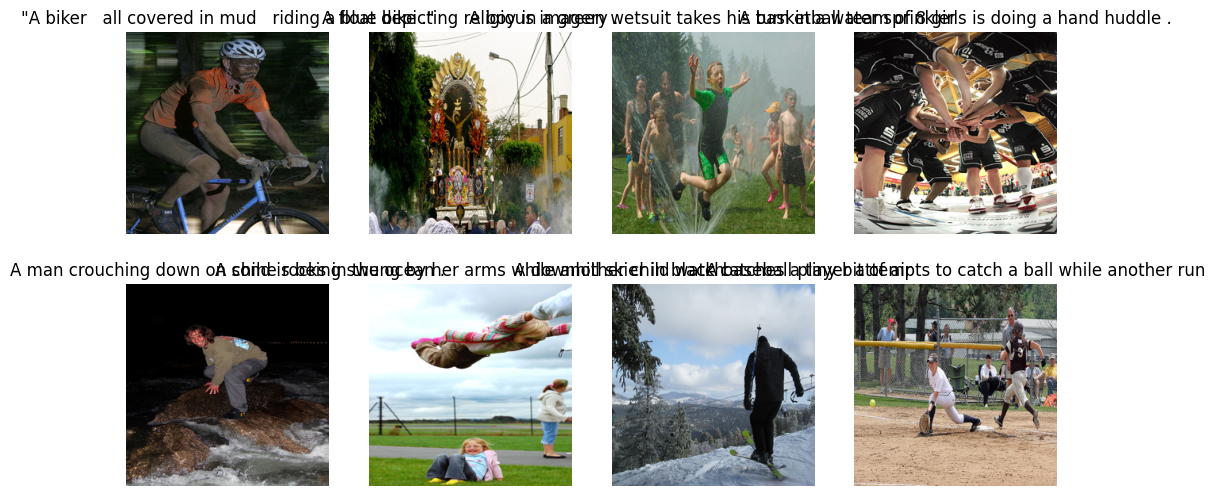

In [ ]:
# Python cell
ds_all = load_dataset("Naveengo/flickr8k")
# This dataset has splits; use 'train' if available
if 'train' in ds_all:
    ds = ds_all['train']
else:
    ds = ds_all

print("Dataset size:", len(ds))
print("Columns:", ds.column_names)
sample = ds[0]
pprint({k: (type(v), (v.size if isinstance(v, Image.Image) else (v[:100] if isinstance(v,str) else str(v)[:100]))) for k,v in sample.items()})

# quick stats
lens = [len(x['text'].split()) for x in ds]
print("Text length (min, mean, max):", min(lens), sum(lens)/len(lens), max(lens))
# resolution stats (sample a subset to save time)
w,h = [],[]
for i in random.sample(range(len(ds)), min(200, len(ds))):
    img = ds[i]['image']
    w.append(img.width); h.append(img.height)
print("Image resolution (sample):", min(w), max(w), min(h), max(h))
# show some samples
samples = [ds[i] for i in random.sample(range(len(ds)), 8)]
show_images_grid([s['image'].resize((256,256)) for s in samples], titles=[s['text'] for s in samples], nrow=4, figsize=(12,6))


In [ ]:
# Python cell
# Option A (CLIP text encoder) - useful if you later use cross-attention style modules.
clip_tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-base-patch32")
clip_text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
clip_text_encoder.eval()

def get_clip_embeddings(texts, max_length=77):
    toks = clip_tokenizer(texts, padding='max_length', truncation=True, max_length=max_length, return_tensors='pt')
    with torch.no_grad():
        out = clip_text_encoder(input_ids=toks.input_ids.to(device), attention_mask=toks.attention_mask.to(device))
        # mean pooling with mask
        emb = out.last_hidden_state  # [B, seq, dim]
        mask = toks.attention_mask.unsqueeze(-1).to(emb.dtype).to(device)
        emb_mean = (emb * mask).sum(1) / mask.sum(1).clamp(min=1e-9)
    return emb_mean.cpu()

# Option B (sentence-transformers) - faster, smaller dims
st_model = SentenceTransformer('all-MiniLM-L6-v2', device=device)
def get_st_embeddings(texts):
    # returns torch tensor on cpu; move to device when using
    embs = st_model.encode(texts, convert_to_tensor=True)
    return embs.cpu()


In [ ]:
# Python cell
image_transform = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# Small subset for quick experiments; increase for real training
SUBSET_SIZE = 2000  # change to 8000 for full Flickr8k
subset = ds.select(range(min(len(ds), SUBSET_SIZE)))

# Precompute ST embeddings (fast) to save repeated tokenization time
texts = [item['text'] for item in subset]
print("Precomputing sentence-transformers embeddings (fast)...")
st_embs = get_st_embeddings(texts)  # cpu tensor [N, dim]
print("Embeddings shape:", st_embs.shape)

class FlickrTorchDataset(Dataset):
    def __init__(self, hf_ds, imgs_transform, text_embs):
        self.ds = hf_ds
        self.transform = imgs_transform
        self.text_embs = text_embs  # cpu tensor
    def __len__(self):
        return len(self.ds)
    def __getitem__(self, idx):
        item = self.ds[idx]
        img = item['image'].convert('RGB')
        if self.transform:
            img = self.transform(img)
        text_emb = self.text_embs[idx]  # cpu tensor
        return img, text_emb

train_ds = FlickrTorchDataset(subset, image_transform, st_embs)
train_loader = DataLoader(train_ds, batch_size=16, shuffle=True, num_workers=2, pin_memory=True)


Precomputing sentence-transformers embeddings (fast)...
Embeddings shape: torch.Size([2000, 384])


In [ ]:
# Python cell
class SelfAttention(nn.Module):
    def __init__(self, in_dim):
        super().__init__()
        self.query = nn.Conv2d(in_dim, in_dim//8, 1)
        self.key = nn.Conv2d(in_dim, in_dim//8, 1)
        self.value = nn.Conv2d(in_dim, in_dim, 1)
        self.gamma = nn.Parameter(torch.zeros(1))
        self.softmax = nn.Softmax(dim=-1)
    def forward(self, x):
        b,c,h,w = x.shape
        q = self.query(x).view(b, -1, h*w).permute(0,2,1) # B, N, C'
        k = self.key(x).view(b, -1, h*w)
        v = self.value(x).view(b, -1, h*w)
        attn = self.softmax(torch.bmm(q,k))
        out = torch.bmm(v, attn.permute(0,2,1)).view(b,c,h,w)
        return self.gamma*out + x

# Mini cross-attention: text tokens (Q) attend to image features (K,V) - demonstration only
class CrossAttentionModule(nn.Module):
    def __init__(self, img_channels, text_dim, num_heads=4):
        super().__init__()
        self.img_to_k = nn.Conv2d(img_channels, text_dim, 1)  # project image -> key/value space
        self.img_to_v = nn.Conv2d(img_channels, text_dim, 1)
        self.q_proj = nn.Linear(text_dim, text_dim)
        self.out = nn.Linear(text_dim, img_channels)
        self.num_heads = num_heads
    def forward(self, img_feat, text_tokens):  # img_feat: B,C,H,W ; text_tokens: B,seq,d
        b,c,h,w = img_feat.shape
        K = self.img_to_k(img_feat).view(b, -1, h*w).permute(0,2,1)  # B, N, d
        V = self.img_to_v(img_feat).view(b, -1, h*w).permute(0,2,1)
        Q = self.q_proj(text_tokens)  # B, seq, d
        attn = torch.softmax(torch.bmm(Q, K.permute(0,2,1)) / math.sqrt(K.size(-1)), dim=-1)  # B, seq, N
        context = torch.bmm(attn, V)  # B, seq, d
        # aggregate across tokens to modulate image
        agg = context.mean(dim=1)  # B, d
        out = self.out(agg).view(b, c, 1, 1)
        return img_feat + out  # modulation


In [ ]:
# Python cell
class Generator64(nn.Module):
    def __init__(self, z_dim=100, text_dim=384, base=64):
        super().__init__()
        self.base = base
        self.project = nn.Linear(z_dim + text_dim, base*8*4*4)
        self.net = nn.Sequential(
            # 4x4 -> 8x8
            nn.ConvTranspose2d(base*8, base*4, 4,2,1),
            nn.BatchNorm2d(base*4),
            nn.ReLU(True),
            # 8->16
            nn.ConvTranspose2d(base*4, base*2, 4,2,1),
            nn.BatchNorm2d(base*2),
            nn.ReLU(True),
            # 16->32
            nn.ConvTranspose2d(base*2, base, 4,2,1),
            nn.BatchNorm2d(base),
            nn.ReLU(True),
            # 32->64
            nn.ConvTranspose2d(base, base//2, 4,2,1),
            nn.BatchNorm2d(base//2),
            nn.ReLU(True),
        )
        self.attn = SelfAttention(base//2)  # attention at 32x32->64x64 stage
        self.to_rgb = nn.Sequential(nn.Conv2d(base//2, 3, 3,1,1), nn.Tanh())
    def forward(self, z, text_emb):
        b = z.size(0)
        x = torch.cat([z, text_emb], dim=1)
        x = self.project(x).view(b, self.base*8, 4, 4)
        x = self.net(x)
        x = self.attn(x)
        return self.to_rgb(x)

class Discriminator64(nn.Module):
    def __init__(self, text_dim=384, base=64):
        super().__init__()
        self.from_rgb = nn.Sequential(
            nn.Conv2d(3, base, 4,2,1), nn.LeakyReLU(0.2, True),
            nn.Conv2d(base, base*2, 4,2,1), nn.BatchNorm2d(base*2), nn.LeakyReLU(0.2, True),
            nn.Conv2d(base*2, base*4, 4,2,1), nn.BatchNorm2d(base*4), nn.LeakyReLU(0.2, True),
            nn.Conv2d(base*4, base*8, 4,2,1), nn.BatchNorm2d(base*8), nn.LeakyReLU(0.2, True),
        )
        self.attn = SelfAttention(base*4)
        self.project_text = nn.Linear(text_dim, base*8*4*4)
        self.final_conv = nn.Sequential(
            nn.Conv2d(base*8, base*8, 3,1,1),
            nn.BatchNorm2d(base*8),
            nn.LeakyReLU(0.2, True),
            nn.AdaptiveAvgPool2d(1)
        )
        self.fc = nn.Linear(base*8, 1)
    def forward(self, img, text_emb):
        h = self.from_rgb(img)    # [B, base*8, 4,4]
        h = self.attn(h)
        t_proj = self.project_text(text_emb).view(h.size(0), -1, 4,4)
        h = h + t_proj
        out = self.final_conv(h).view(h.size(0), -1)
        return self.fc(out).squeeze(1)


In [ ]:
import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
import numpy as np
from PIL import Image
from tqdm import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"

def show_images_grid(tensor, titles=None, nrow=4):
    grid = make_grid(tensor, nrow=nrow, normalize=True)
    plt.figure(figsize=(10, 10))
    plt.axis("off")
    plt.imshow(np.transpose(grid.cpu(), (1,2,0)))
    plt.show()


In [ ]:
class SimpleTextImageDataset(Dataset):
    def __init__(self, n=500, size=64):
        self.n = n
        self.size = size
        self.texts = [f"colorful pattern {i}" for i in range(n)]
        self.images = [Image.fromarray((np.random.rand(size, size, 3)*255).astype('uint8')) for _ in range(n)]
        self.emb_model = SentenceTransformer("all-MiniLM-L6-v2")

        self.transform = transforms.Compose([
            transforms.Resize((size, size)),
            transforms.ToTensor()
        ])

    def __len__(self): return self.n

    def __getitem__(self, i):
        img = self.transform(self.images[i])
        emb = torch.tensor(self.emb_model.encode(self.texts[i]), dtype=torch.float32)
        return img, emb

train_loader = DataLoader(SimpleTextImageDataset(), batch_size=16, shuffle=True)


In [ ]:
class Generator64(nn.Module):
    def __init__(self, z_dim=100, text_dim=384):
        super().__init__()
        self.fc = nn.Linear(z_dim + text_dim, 512*4*4)
        self.deconv = nn.Sequential(
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.ConvTranspose2d(512, 256, 4, 2, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 3, 4, 2, 1),
            nn.Tanh()
        )
    def forward(self, z, text_emb):
        x = torch.cat([z, text_emb], 1)
        x = self.fc(x).view(-1, 512, 4, 4)
        return self.deconv(x)

class Discriminator64(nn.Module):
    def __init__(self, text_dim=384):
        super().__init__()
        self.img_conv = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1), nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, 4, 2, 1), nn.BatchNorm2d(128), nn.LeakyReLU(0.2),
            nn.Conv2d(128, 256, 4, 2, 1), nn.BatchNorm2d(256), nn.LeakyReLU(0.2),
            nn.Conv2d(256, 512, 4, 2, 1), nn.BatchNorm2d(512), nn.LeakyReLU(0.2),
        )
        # project text to 512 channels to match image features
        self.text_proj = nn.Linear(text_dim, 512)
        self.conv_joint = nn.Conv2d(1024, 1, 4)  # image(512) + text(512)
    def forward(self, img, text_emb):
        x = self.img_conv(img)
        t = self.text_proj(text_emb).unsqueeze(2).unsqueeze(3)
        t = t.expand(-1, 512, 4, 4)
        joint = torch.cat([x, t], 1)
        return self.conv_joint(joint).view(-1)


/tmp/ipython-input-1800262011.py:11: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
Epoch 1/5:   0%|          | 0/32 [00:00<?, ?it/s]/tmp/ipython-input-1800262011.py:24: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-1800262011.py:35: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 1/5: 100%|██████████| 32/32 [00:05<00:00,  6.26it/s]


Epoch 1: LossD=2.2992, LossG=12.0703


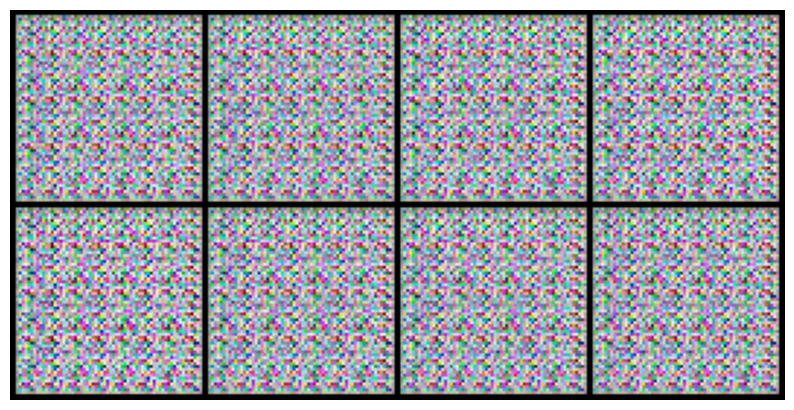

Epoch 2/5: 100%|██████████| 32/32 [00:04<00:00,  7.21it/s]


Epoch 2: LossD=0.0280, LossG=7.1941


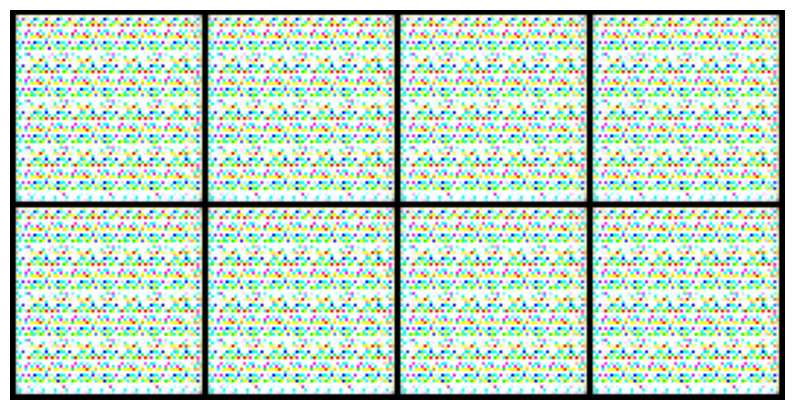

Epoch 3/5: 100%|██████████| 32/32 [00:03<00:00,  8.39it/s]


Epoch 3: LossD=0.0068, LossG=6.0658


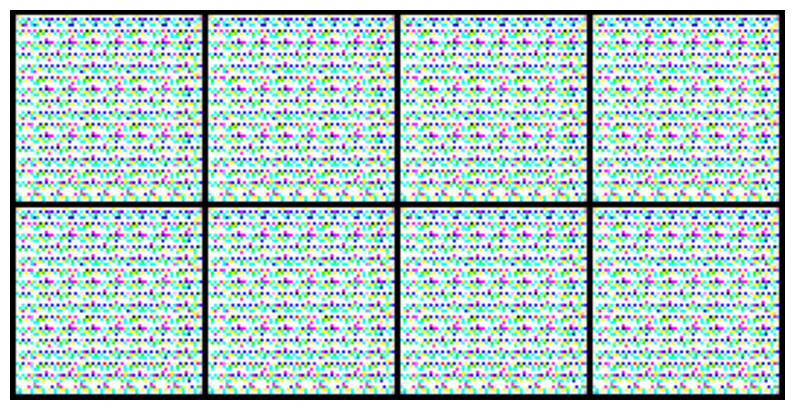

Epoch 4/5: 100%|██████████| 32/32 [00:03<00:00,  8.23it/s]


Epoch 4: LossD=0.1023, LossG=5.4632


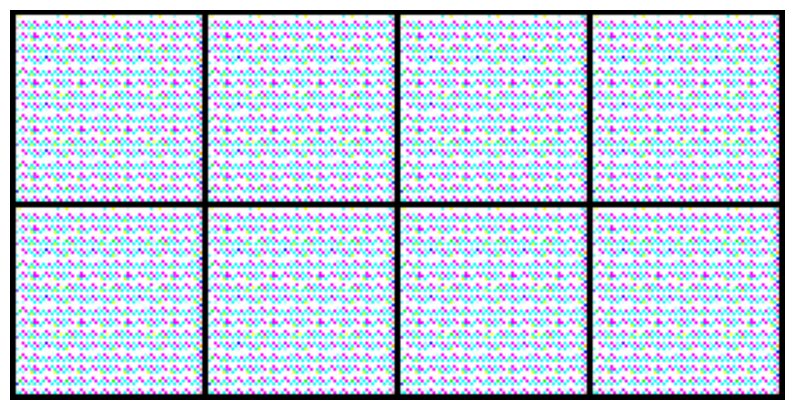

Epoch 5/5: 100%|██████████| 32/32 [00:04<00:00,  6.95it/s]


Epoch 5: LossD=0.0045, LossG=6.5327


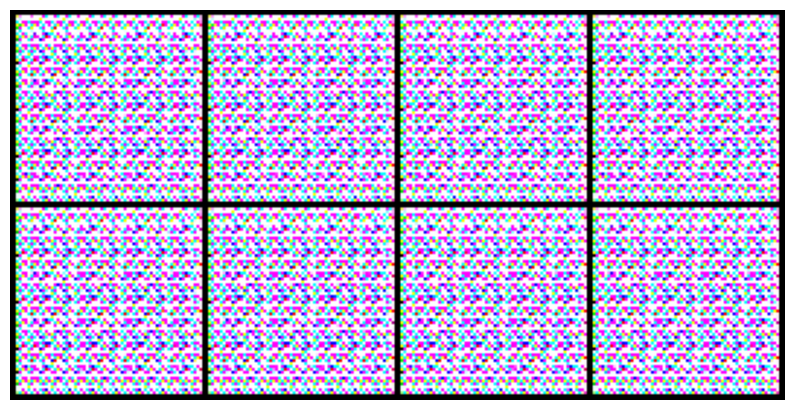

In [ ]:
from torch.cuda.amp import autocast, GradScaler

z_dim = 100
text_dim = 384
G = Generator64(z_dim, text_dim).to(device)
D = Discriminator64(text_dim).to(device)

optG = torch.optim.Adam(G.parameters(), lr=2e-4, betas=(0.5, 0.999))
optD = torch.optim.Adam(D.parameters(), lr=2e-4, betas=(0.5, 0.999))
bce = nn.BCEWithLogitsLoss()
scaler = GradScaler()

epochs = 5
for epoch in range(epochs):
    for imgs, text_emb in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
        imgs, text_emb = imgs.to(device), text_emb.to(device)
        b = imgs.size(0)
        z = torch.randn(b, z_dim, device=device)
        real_labels = torch.ones(b, device=device)
        fake_labels = torch.zeros(b, device=device)

        # --- Train D ---
        optD.zero_grad()
        with autocast():
            real_out = D(imgs, text_emb)
            fake_imgs = G(z, text_emb)
            fake_out = D(fake_imgs.detach(), text_emb)
            lossD = (bce(real_out, real_labels) + bce(fake_out, fake_labels)) / 2
        scaler.scale(lossD).backward()
        scaler.step(optD)
        scaler.update()

        # --- Train G ---
        optG.zero_grad()
        with autocast():
            fake_out = D(fake_imgs, text_emb)
            lossG = bce(fake_out, real_labels)
        scaler.scale(lossG).backward()
        scaler.step(optG)
        scaler.update()

    print(f"Epoch {epoch+1}: LossD={lossD.item():.4f}, LossG={lossG.item():.4f}")
    with torch.no_grad():
        G.eval()
        z = torch.randn(8, z_dim, device=device)
        sample_embs = next(iter(train_loader))[1][:8].to(device)
        samples = G(z, sample_embs)
        show_images_grid(samples)


In [ ]:
class SelfAttention(nn.Module):
    def __init__(self, in_dim):
        super().__init__()
        self.query = nn.Conv2d(in_dim, in_dim // 8, 1)
        self.key   = nn.Conv2d(in_dim, in_dim // 8, 1)
        self.value = nn.Conv2d(in_dim, in_dim, 1)
        self.gamma = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        B, C, H, W = x.size()
        proj_query = self.query(x).view(B, -1, H * W).permute(0, 2, 1)
        proj_key = self.key(x).view(B, -1, H * W)
        energy = torch.bmm(proj_query, proj_key)
        attention = F.softmax(energy, dim=-1)
        proj_value = self.value(x).view(B, -1, H * W)

        out = torch.bmm(proj_value, attention.permute(0, 2, 1))
        out = out.view(B, C, H, W)
        return self.gamma * out + x


In [ ]:
class AttnGenerator64(nn.Module):
    def __init__(self, z_dim=100, text_dim=384):
        super().__init__()
        self.fc = nn.Linear(z_dim + text_dim, 512 * 4 * 4)
        self.deconv = nn.Sequential(
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.ConvTranspose2d(512, 256, 4, 2, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            SelfAttention(256),   # << added here
            nn.ConvTranspose2d(256, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 3, 4, 2, 1),
            nn.Tanh()
        )
    def forward(self, z, text_emb):
        x = torch.cat([z, text_emb], 1)
        x = self.fc(x).view(-1, 512, 4, 4)
        return self.deconv(x)


In [ ]:
class AttnDiscriminator64(nn.Module):
    def __init__(self, text_dim=384):
        super().__init__()
        self.img_conv = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1), nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, 4, 2, 1), nn.BatchNorm2d(128), nn.LeakyReLU(0.2),
            SelfAttention(128),   # << added here
            nn.Conv2d(128, 256, 4, 2, 1), nn.BatchNorm2d(256), nn.LeakyReLU(0.2),
            nn.Conv2d(256, 512, 4, 2, 1), nn.BatchNorm2d(512), nn.LeakyReLU(0.2),
        )
        self.text_proj = nn.Linear(text_dim, 512)
        self.conv_joint = nn.Conv2d(1024, 1, 4)
    def forward(self, img, text_emb):
        x = self.img_conv(img)
        t = self.text_proj(text_emb).unsqueeze(2).unsqueeze(3)
        t = t.expand(-1, 512, 4, 4)
        joint = torch.cat([x, t], 1)
        return self.conv_joint(joint).view(-1)


/tmp/ipython-input-2965570534.py:11: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
Epoch 1/5:   0%|          | 0/32 [00:00<?, ?it/s]/tmp/ipython-input-2965570534.py:24: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-2965570534.py:35: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 1/5: 100%|██████████| 32/32 [00:03<00:00,  8.19it/s]


Epoch 1: LossD=0.0816, LossG=9.8848


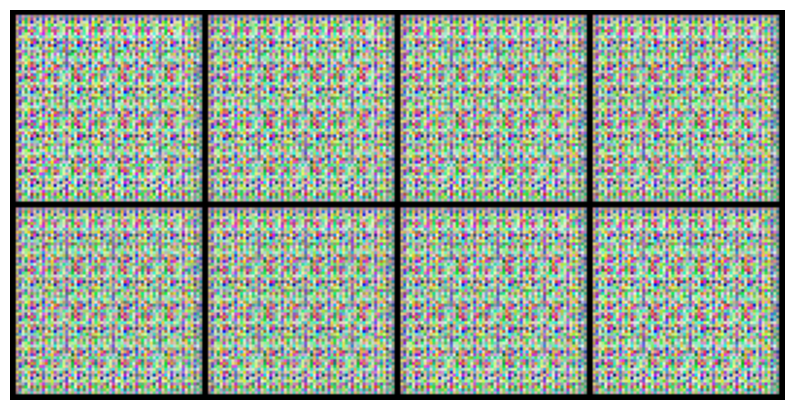

Epoch 2/5: 100%|██████████| 32/32 [00:04<00:00,  8.00it/s]


Epoch 2: LossD=0.0291, LossG=4.8991


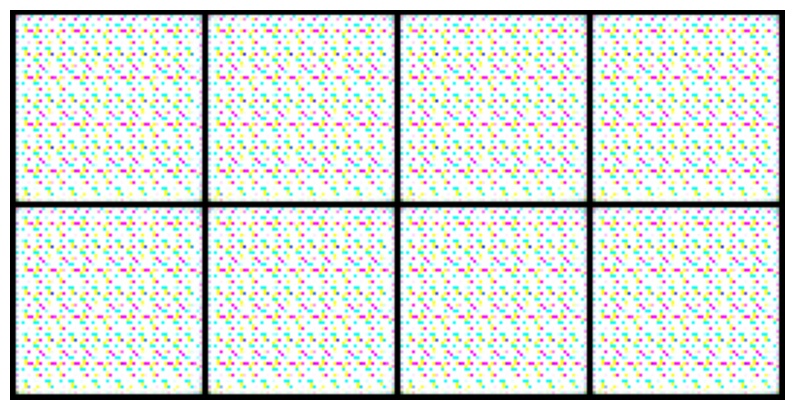

Epoch 3/5: 100%|██████████| 32/32 [00:04<00:00,  6.85it/s]


Epoch 3: LossD=0.0088, LossG=5.6442


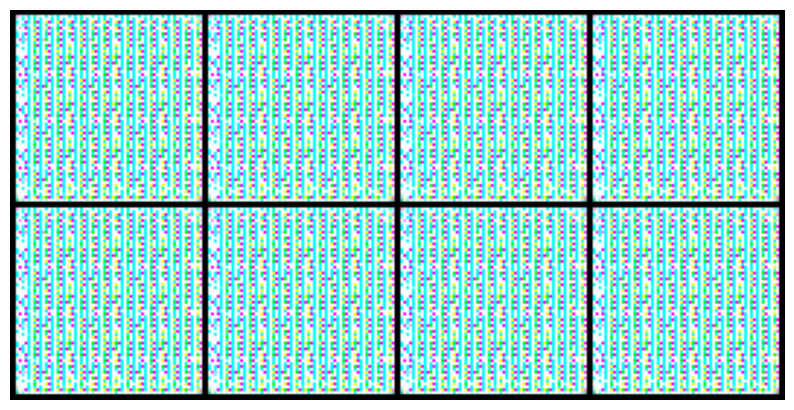

Epoch 4/5: 100%|██████████| 32/32 [00:04<00:00,  7.79it/s]


Epoch 4: LossD=0.0057, LossG=6.4986


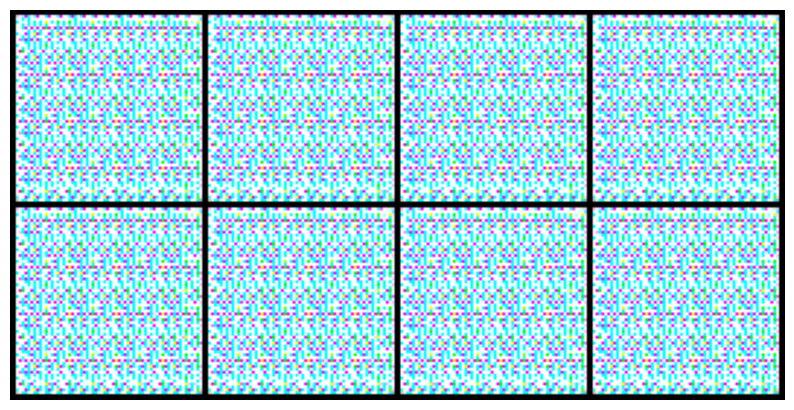

Epoch 5/5: 100%|██████████| 32/32 [00:04<00:00,  6.95it/s]


Epoch 5: LossD=0.0029, LossG=6.7463


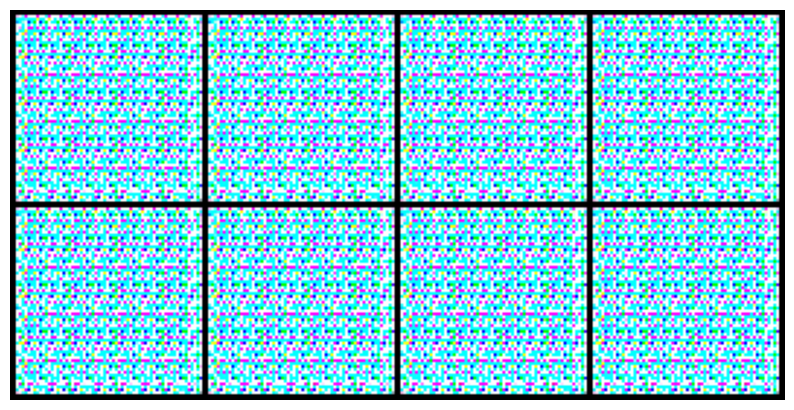

In [ ]:
from torch.cuda.amp import autocast, GradScaler

z_dim = 100
text_dim = 384
G = AttnGenerator64(z_dim, text_dim).to(device)
D = AttnDiscriminator64(text_dim).to(device)

optG = torch.optim.Adam(G.parameters(), lr=2e-4, betas=(0.5, 0.999))
optD = torch.optim.Adam(D.parameters(), lr=2e-4, betas=(0.5, 0.999))
bce = nn.BCEWithLogitsLoss()
scaler = GradScaler()

epochs = 5
for epoch in range(epochs):
    for imgs, text_emb in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
        imgs, text_emb = imgs.to(device), text_emb.to(device)
        b = imgs.size(0)
        z = torch.randn(b, z_dim, device=device)
        real_labels = torch.ones(b, device=device)
        fake_labels = torch.zeros(b, device=device)

        # --- Train D ---
        optD.zero_grad()
        with autocast():
            real_out = D(imgs, text_emb)
            fake_imgs = G(z, text_emb)
            fake_out = D(fake_imgs.detach(), text_emb)
            lossD = (bce(real_out, real_labels) + bce(fake_out, fake_labels)) / 2
        scaler.scale(lossD).backward()
        scaler.step(optD)
        scaler.update()

        # --- Train G ---
        optG.zero_grad()
        with autocast():
            fake_out = D(fake_imgs, text_emb)
            lossG = bce(fake_out, real_labels)
        scaler.scale(lossG).backward()
        scaler.step(optG)
        scaler.update()

    print(f"Epoch {epoch+1}: LossD={lossD.item():.4f}, LossG={lossG.item():.4f}")
    with torch.no_grad():
        G.eval()
        z = torch.randn(8, z_dim, device=device)
        sample_embs = next(iter(train_loader))[1][:8].to(device)
        samples = G(z, sample_embs)
        show_images_grid(samples)


In [ ]:
import os, shutil
from PIL import Image

export_dir = "/content/instance_images"
os.makedirs(export_dir, exist_ok=True)

for i in range(500):
    item = subset[i]
    img = item["image"]
    img.save(os.path.join(export_dir, f"img_{i:04d}.jpg"))


In [ ]:
captions = [subset[i]["text"] for i in range(500)]
with open("/content/captions.txt", "w") as f:
    for i, cap in enumerate(captions):
        f.write(f"img_{i:04d}.jpg|{cap}\n")


In [ ]:
!pip install -q diffusers==0.31.0 transformers accelerate safetensors bitsandbytes
!pip install -q peft datasets


In [ ]:
from huggingface_hub import notebook_login
notebook_login()


In [ ]:
# ✅ Step 2: Load Pretrained Stable Diffusion Pipeline (latest syntax)
from diffusers import StableDiffusionPipeline
import torch

model_id = "runwayml/stable-diffusion-v1-5"

# load model properly
pipe = StableDiffusionPipeline.from_pretrained(model_id, dtype=torch.float16).to("cuda")

# test one generation
prompt = "a scenic painting of a mountain under the stars"
image = pipe(prompt).images[0]
image.show()


    PyTorch 2.4.0+cu121 with CUDA 1201 (you have 2.6.0+cu124)
    Python  3.12.4 (you have 3.12.12)
  Please reinstall xformers (see https://github.com/facebookresearch/xformers#installing-xformers)
  Memory-efficient attention, SwiGLU, sparse and more won't be available.
  Set XFORMERS_MORE_DETAILS=1 for more details
/usr/local/lib/python3.12/dist-packages/xformers/ops/fmha/flash.py:211: FutureWarning: `torch.library.impl_abstract` was renamed to `torch.library.register_fake`. Please use that instead; we will remove `torch.library.impl_abstract` in a future version of PyTorch.
  @torch.library.impl_abstract("xformers_flash::flash_fwd")
/usr/local/lib/python3.12/dist-packages/xformers/ops/fmha/flash.py:344: FutureWarning: `torch.library.impl_abstract` was renamed to `torch.library.register_fake`. Please use that instead; we will remove `torch.library.impl_abstract` in a future version of PyTorch.
  @torch.library.impl_abstract("xformers_flash::flash_bwd")
Keyword arguments {'dtype': to

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

In [ ]:
# !pip install torch==2.6.0 torchvision==0.21.0 torchaudio==2.6.0 --force-reinstall


  0%|          | 0/50 [00:00<?, ?it/s]

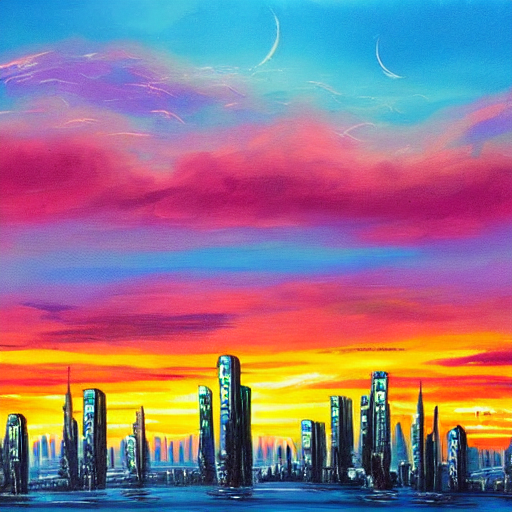

In [ ]:
from IPython.display import display

prompt = "a painting of a sunset over a futuristic city, vibrant colors"
result = pipe(prompt)

# Display the image directly in the notebook
display(result.images[0])

# Optional: Save it too
result.images[0].save("generated_image.png")


In [ ]:
# !pip install diffusers transformers accelerate safetensors
!git clone https://github.com/huggingface/diffusers.git
!pip install -U -r diffusers/examples/textual_inversion/requirements.txt


fatal: destination path 'diffusers' already exists and is not an empty directory.
  Using cached torchvision-0.24.0-cp312-cp312-manylinux_2_28_x86_64.whl.metadata (5.9 kB)
  Using cached torch-2.9.0-cp312-cp312-manylinux_2_28_x86_64.whl.metadata (30 kB)
  Using cached sympy-1.14.0-py3-none-any.whl.metadata (12 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.8.93-py3-none-manylinux2010_x86_64.manylinux_2_12_x86_64.whl.metadata (1.7 kB)
  Using cached nvidia_cuda_runtime_cu12-12.8.90-py3-none-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (1.7 kB)
  Using cached nvidia_cuda_cupti_cu12-12.8.90-py3-none-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (1.7 kB)
  Using cached nvidia_cudnn_cu12-9.10.2.21-py3-none-manylinux_2_27_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_cublas_cu12-12.8.4.1-py3-none-manylinux_2_27_x86_64.whl.metadata (1.7 kB)
  Using cached nvidia_cufft_cu12-11.3.3.83-py3-none-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (1.7 kB)
  Using cache

In [ ]:
!pip uninstall -y diffusers
!git clone https://github.com/huggingface/diffusers.git
%cd diffusers
!pip install -e .


Found existing installation: diffusers 0.31.0
Uninstalling diffusers-0.31.0:
  Successfully uninstalled diffusers-0.31.0
fatal: destination path 'diffusers' already exists and is not an empty directory.
/content/diffusers
Obtaining file:///content/diffusers
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for diffusers (pyproject.toml) ... done
  Created wheel for diffusers: filename=diffusers-0.36.0.dev0-0.editable-py3-none-any.whl size=11374 sha256=1ebd194d046db257f012fe7102ea778f86dca65165eeff2f042adafa4a7e2622
  Stored in directory: /tmp/pip-ephem-wheel-cache-3vgk184z/wheels/8a/fc/09/385efb77b455b2fd4a656c950079c93147e1f50ae614e51beb
Successfully built diffusers


In [ ]:
%cd /content


/content


In [ ]:
!accelerate launch diffusers/examples/textual_inversion/textual_inversion.py \
  --pretrained_model_name_or_path="runwayml/stable-diffusion-v1-5" \
  --train_data_dir="/content/instance_images" \
  --learnable_property="object" \
  --placeholder_token="<mytoken>" \
  --initializer_token="photo" \
  --resolution=512 \
  --train_batch_size=1 \
  --gradient_accumulation_steps=4 \
  --max_train_steps=1000 \
  --learning_rate=5e-04 \
  --scale_lr \
  --output_dir="/content/textual_inversion_output"



The following values were not passed to `accelerate launch` and had defaults used instead:
	`--num_processes` was set to a value of `1`
	`--num_machines` was set to a value of `1`
	`--mixed_precision` was set to a value of `'no'`
	`--dynamo_backend` was set to a value of `'no'`
To avoid this warning pass in values for each of the problematic parameters or run `accelerate config`.
2025-10-28 14:59:23.008463: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1761663563.042738   29556 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761663563.054289   29556 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1761663563.080808   29556 computation_plac

In [ ]:
from diffusers import StableDiffusionPipeline
import torch

pipe = StableDiffusionPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    torch_dtype=torch.float16
).to("cuda")

pipe.load_textual_inversion("/content/textual_inversion_output", token="<mytoken>")

prompt = "a photo of <mytoken> in a forest"
image = pipe(prompt).images[0]
image.save("/content/output_image.png")


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`torch_dtype` is deprecated! Use `dtype` instead!
The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


RuntimeError: Error in dlopen: /usr/local/lib/python3.12/dist-packages/torch/lib/libtorch_cuda_linalg.so: undefined symbol: _ZN3c105ErrorC2ENS_14SourceLocationENSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE